<a href="https://colab.research.google.com/github/dhanunjaireddy07/Breast-Cancer-Diagnosis-Using-Ensemble-Methods/blob/main/BreastCancerPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression  # Correct import for LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
import os

In [2]:
# DATA LOADING AND PREPROCESS
if not os.path.exists('wbdd.csv'):
    raise FileNotFoundError("The dataset 'data.csv' was not found.")
df = pd.read_csv('data.csv')
df.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kpca = KernelPCA(n_components=15, kernel='rbf', gamma=0.05, random_state=42)
X_kpca = kpca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_kpca, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:

# SVM Model
svm_model = SVC(C=0.1, kernel='rbf', gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# MLP Model - Improved for higher accuracy
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),  # Increased hidden layers and neurons
    activation='relu',
    solver='adam',
    alpha=0.001,  # Slight regularization to prevent overfitting
    learning_rate_init=0.001,  # Optimized learning rate
    max_iter=2000,  # Increased iterations for better convergence
    random_state=42,
    tol=1e-4,
    early_stopping=True,  # Early stopping for regularization
    validation_fraction=0.1,  # Use a fraction of training data for early stopping
    n_iter_no_change=20  # Early stop after 20 iterations without improvement
)
mlp_model.fit(X_train, y_train)

MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(100, 50, 25), max_iter=2000,
              n_iter_no_change=20, random_state=42)

In [4]:
# Soft Voting Ensemble - Enhanced with more models (XGBoost and RandomForest)
extra_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

soft_voting_improved = VotingClassifier(
    estimators=[('svm', svm_model), ('mlp', mlp_model), ('rf', RandomForestClassifier(n_estimators=100, random_state=42)), ('xgb', extra_model)],
    voting='soft'
)
soft_voting_improved.fit(X_train, y_train)

# Stacking Ensemble - Improved with stronger base models and better meta-model
base_models = [
    ('svm', svm_model),
    ('mlp', mlp_model),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
]

# Use a Logistic Regression as the meta-model
meta_model = LogisticRegression(random_state=42, max_iter=1000)

stacking_improved = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True, cv=5
)
stacking_improved.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('svm',
                                SVC(C=0.1, probability=True, random_state=42)),
                               ('mlp',
                                MLPClassifier(alpha=0.001, early_stopping=True,
                                              hidden_layer_sizes=(100, 50, 25),
                                              max_iter=2000,
                                              n_iter_no_change=20,
                                              random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   passthrough=True)

In [5]:


# Cross-Validation
def cross_validate_model(model, X, y, model_name):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"======== {model_name} with Cross-Validation ========")
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")
    print("\n")

# Evaluate Cross-Validation for each model
models = {
    "SVM": svm_model,
    "MLP": mlp_model,
    "Soft Voting Ensemble": soft_voting_improved,
    "Stacking Ensemble": stacking_improved
}

for name, model in models.items():
    cross_validate_model(model, X_train, y_train, name)



======== SVM with Cross-Validation ========
Cross-Validation Accuracy Scores: [0.93406593 0.96703297 0.92307692 0.92307692 0.92307692]
Mean Accuracy: 0.9341
Standard Deviation: 0.0170


======== MLP with Cross-Validation ========
Cross-Validation Accuracy Scores: [0.94505495 0.92307692 0.94505495 0.93406593 0.94505495]
Mean Accuracy: 0.9385
Standard Deviation: 0.0088


======== Soft Voting Ensemble with Cross-Validation ========
Cross-Validation Accuracy Scores: [0.93406593 1.         0.95604396 0.95604396 0.94505495]
Mean Accuracy: 0.9582
Standard Deviation: 0.0224


======== Stacking Ensemble with Cross-Validation ========
Cross-Validation Accuracy Scores: [0.93406593 1.         0.95604396 0.96703297 0.93406593]
Mean Accuracy: 0.9582
Standard Deviation: 0.0245





======== SVM ========
Accuracy: 0.9122807017543859

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93        72
           1       0.90      0.86      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



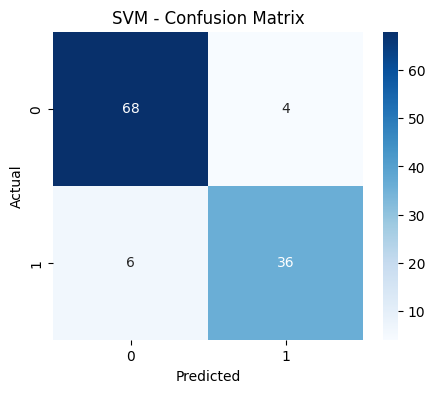

ROC AUC Score: 0.9854497354497354


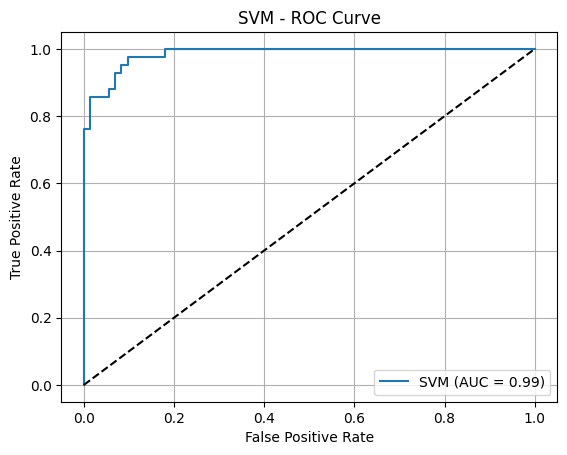


======== MLP ========
Accuracy: 0.9385964912280702

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



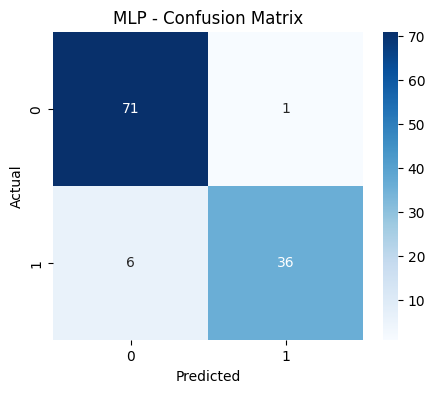

ROC AUC Score: 0.986111111111111


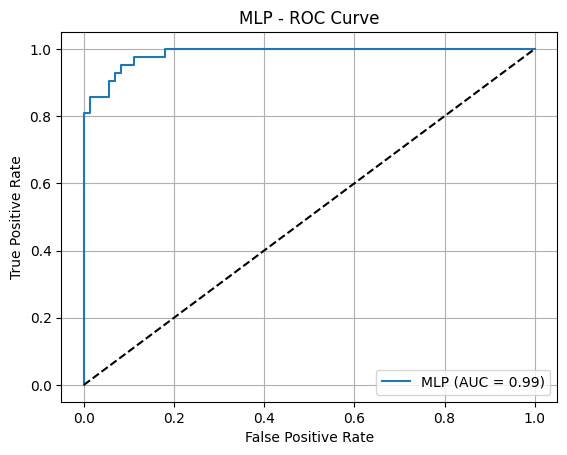


======== Soft Voting Ensemble ========
Accuracy: 0.956140350877193

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



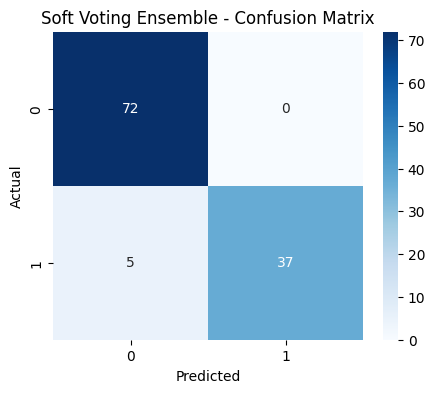

ROC AUC Score: 0.990410052910053


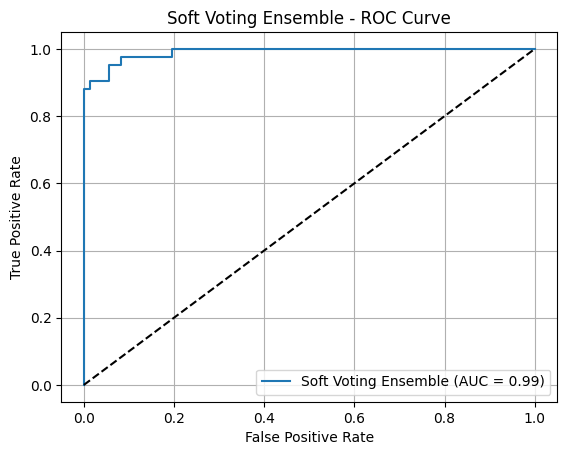


======== Stacking Ensemble ========
Accuracy: 0.956140350877193

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



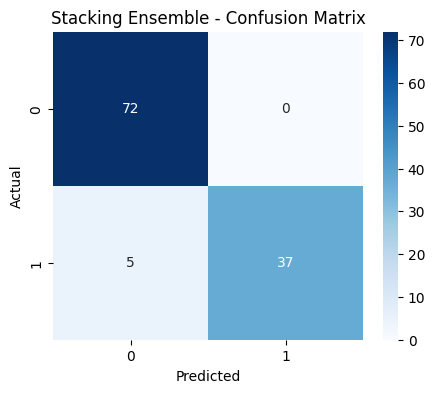

ROC AUC Score: 0.9927248677248677


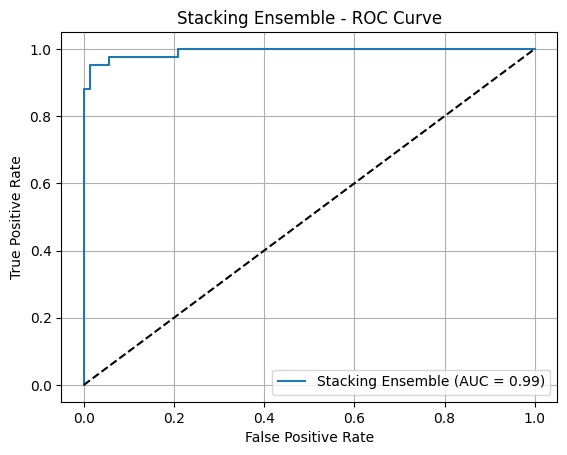

In [6]:
# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"\n======== {model_name} ========")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

# Evaluate all models
for name, model in models.items():
    evaluate_model(model, X_test, y_test, name)


In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

# SVM Tuning - narrow range around current C=0.1
svm_params = {
    'C': [0.09, 0.1, 0.11],
    'gamma': ['scale', 0.04, 0.05],
    'kernel': ['rbf']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='accuracy', refit=True)
svm_grid.fit(X_train, y_train)
svm_model = svm_grid.best_estimator_
print("SVM best params (tuned, narrow):", svm_grid.best_params_)

# MLP Tuning - centered around your current setup
mlp_params = {
    'hidden_layer_sizes': [(100, 50, 25), (100, 60, 20)],
    'alpha': [0.001, 0.002],
    'learning_rate_init': [0.001, 0.002],
    'max_iter': [2000],
    'tol': [1e-4, 1e-3]
}
mlp_grid = GridSearchCV(
    MLPClassifier(
        activation='relu',
        solver='adam',
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20
    ),
    mlp_params,
    cv=5,
    scoring='accuracy',
    refit=True
)
mlp_grid.fit(X_train, y_train)
mlp_model = mlp_grid.best_estimator_
print("MLP best params (tuned, narrow):", mlp_grid.best_params_)


SVM best params (tuned, narrow): {'C': 0.11, 'gamma': 'scale', 'kernel': 'rbf'}
MLP best params (tuned, narrow): {'alpha': 0.001, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.002, 'max_iter': 2000, 'tol': 0.0001}
